In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from misc import *
from dataset import *

import torch.nn as nn
import torch.optim as optim

from tqdm.auto import tqdm, trange

device = torch.device('cuda:0')

torch.manual_seed(222)
np.random.seed(333)

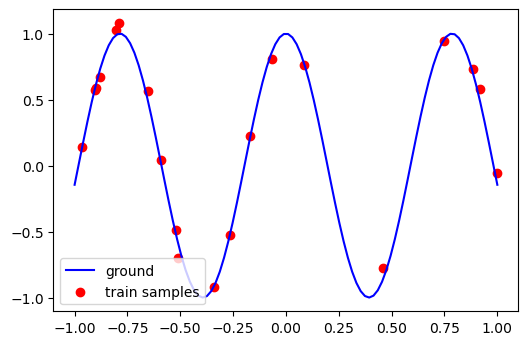

In [2]:
def sinuous(x):
    y = np.sin(8*x+0.5*np.pi)
    return y
    
Ntr = 20
noise = 5e-2
    
Xtr = np.random.uniform(-1,1, size=[Ntr,1])
ytr = sinuous(Xtr)
epsi = noise*np.random.normal(size=ytr.shape)

ytr = ytr+epsi

Xte = np.linspace(-1,1,100).reshape([-1,1])
yte = sinuous(Xte)

fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(Xte.squeeze(), yte.squeeze(), color='b', label='ground')
plt.scatter(Xtr.squeeze(), ytr.squeeze(), color='r', label='train samples')
plt.legend()

dataset_train = SimpleDataset(Xtr, ytr)
dataset_test = SimpleDataset(Xte, yte)


In [3]:
class Net(nn.Module):
    def __init__(self, config, act=nn.Tanh()):
        
        super(Net, self).__init__()
 
        layers_list = []

        for l in range(len(config)-2):
            in_dim = config[l]
            out_dim = config[l+1]
            
            layers_list.append(nn.Linear(in_features=in_dim, out_features=out_dim))
            layers_list.append(nn.Tanh())
            
        #
        
        # last layer
        layers_list.append(nn.Linear(in_features=config[-2], out_features=config[-1]))
        
        self.net = nn.ModuleList(layers_list)
        
    def forward(self, X):
        h = X
        for layer in self.net:
            h = layer(h)
        #
        return h



In [4]:
epochs=5000
lr=0.18

train_loader = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

config = [1,64,64,1]
model = Net(config).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.99, verbose=False)

for ie in tqdm(range(epochs+1)):
    
    Xtr, ytr = next(iter(train_loader))
    Xte, yte = next(iter(test_loader))
    
    Xtr, ytr, Xte, yte = \
        Xtr.float().to(device), ytr.float().to(device), Xte.float().to(device), yte.float().to(device)
    
    pred = model(Xtr)
    loss = torch.mean(torch.square(pred-ytr))
    

    # step 1: clear the grads
    optimizer.zero_grad()
    # step 2: backward the computational graph
    loss.backward()
    # step 3: take the gradient step
    optimizer.step()
    
    scheduler.step()
    
    if ie%500 == 0:
        cprint('r', 'Epoch #{}\t: '.format(ie), end='')
        with torch.no_grad():
            rmse_tr = torch.sqrt(torch.mean(torch.square(ytr-pred)))
            rmse_te = torch.sqrt(torch.mean(torch.square(yte-model(Xte))))
            print('train_rmse={:.5f}, test_rmse={:.5f}'.format(rmse_tr.item(), rmse_te.item()))
            
        #
    #


  0%|          | 0/5001 [00:00<?, ?it/s]

Epoch #0	: train_rmse=0.74397, test_rmse=1.09134
Epoch #500	: train_rmse=0.41829, test_rmse=0.58356
Epoch #1000	: train_rmse=0.51305, test_rmse=0.60027
Epoch #1500	: train_rmse=0.19348, test_rmse=0.19812
Epoch #2000	: train_rmse=0.21004, test_rmse=0.22125
Epoch #2500	: train_rmse=0.20213, test_rmse=0.23786
Epoch #3000	: train_rmse=0.21277, test_rmse=0.35370
Epoch #3500	: train_rmse=0.10465, test_rmse=0.27396
Epoch #4000	: train_rmse=0.07151, test_rmse=0.31457
Epoch #4500	: train_rmse=0.07106, test_rmse=0.33770
Epoch #5000	: train_rmse=0.04198, test_rmse=0.33633


train_rmse=0.02609, test_rmse=0.34207


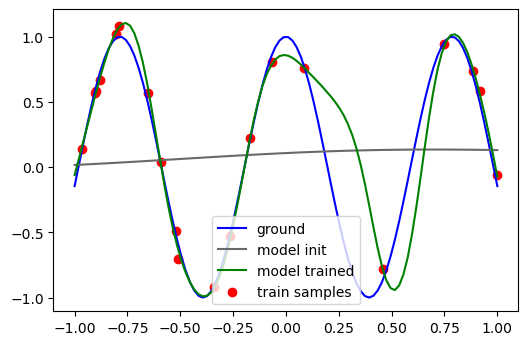

In [5]:
lr=0.1

train_loader = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

config = [1,64,64,1]
model = Net(config).to(device)

optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=500)

Xtr, ytr = next(iter(train_loader))
Xte, yte = next(iter(test_loader))

Xtr, ytr, Xte, yte = \
    Xtr.float().to(device), ytr.float().to(device), Xte.float().to(device), yte.float().to(device)

def closure():
    optimizer.zero_grad()
    pred = model(Xtr)
    loss = torch.mean(torch.square(pred-ytr))
    loss.backward(retain_graph=True)
    #print('loss:%g'%loss.item())
    return loss
#

with torch.no_grad():
    pred_before = model(Xte)

optimizer.step(closure)

with torch.no_grad():
    rmse_tr = torch.sqrt(torch.mean(torch.square(ytr-model(Xtr))))
    rmse_te = torch.sqrt(torch.mean(torch.square(yte-model(Xte))))
    print('train_rmse={:.5f}, test_rmse={:.5f}'.format(rmse_tr.item(), rmse_te.item()))
#

with torch.no_grad():
    pred_after = model(Xte)

fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(Xte.cpu().squeeze(), yte.cpu().squeeze(), color='b', label='ground')
plt.scatter(Xtr.cpu().squeeze(), ytr.cpu().squeeze(), color='r', label='train samples')
plt.plot(Xte.cpu().squeeze(), pred_before.cpu().squeeze(), color='dimgray', label='model init')
plt.plot(Xte.cpu().squeeze(), pred_after.cpu().squeeze(), color='green', label='model trained')
plt.legend()